# Background Computation with "ofilter"

This notebook illustrate background calculations using `ofilter` algorithm adapted from IRAF.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

import ofiltsky

%matplotlib inline

### Generate Data

In [17]:
# Set the seed for reproducibility
np.random.seed(0)

# Random Poisson data
data = np.random.poisson(lam=1, size=(50, 50))

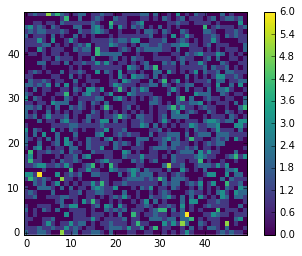

In [3]:
plt.imshow(data, cmap='viridis', interpolation='none')
plt.colorbar()

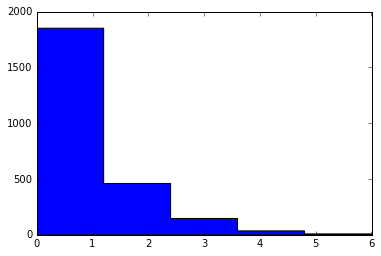

In [4]:
h = plt.hist(data.flatten(), bins=5, histtype='stepfilled')

### Quick IRAF Detour

To write this data out for IRAF, uncomment and run the following:

In [5]:
# from astropy.io import fits
#
# hdu0 = fits.PrimaryHDU()
# hdu1 = fits.ImageHDU(data.astype(np.float32))
# hdu = fits.HDUList([hdu0, hdu1])
# hdu.writeto('im_poisson_0.fits', clobber=True)

In addition to the FITS file, you also have to create an one-liner `im_poisson_0.coo` file with the following contents:

    25 25
    
Inside your IRAF session, set the following parameters (more or less) using `epar`:

    datapars.sigma = 1.
    fitskypars.salgo = "ofilter"
    fitskypars.annulus = 1.
    fitskypars.dannulus = 20.
    fitskypars.smaxiter = 10
    fitskypars.snreject = 10
    
Then, run the following command:

    fitsky im_poisson_0.fits im_poisson_0.coo
    
The result would be in `im_poisson_0.fits1.sky.1`:

    MSKY = 0.7501966
    STDEV = 0.7515768
    SSKEW = 0.5060266

### Back to Python

For this dataset, Python version of the `ofilter` algorithm gives slightly lower sky and skew values, but comparable sigma. The Python version uses third-party libraries like Numpy, Scipy, and Astropy. Thus, it is not shocking that we are not getting complete agreement here.

Some questions that could be pursued:

1. Is it good enough? (Also see the next sub-section.)
2. Do we even care about the skew? Maybe not? In Python, it is calculated using `scipy.stats.skew()`.

In [23]:
np.ceil(data.std())

1.0

In [24]:
# NOTE: Sigma clipping does not matter much for this dataset.
ofil_results = ofiltsky.fitsky_ofilter(data, binsize=data.std(), sigclip_sigma=None)

print('MSKY =', ofil_results[0])
print('STDEV =', ofil_results[1])
print('SSKEW =', ofil_results[2])

MSKY = 0.92918132758
STDEV = 0.747370581312
SSKEW = 0.3443684652164396


We can also compare with some other available statistics:

In [7]:
sky_mean = data.mean()
sky_med = np.median(data)
sky_mode = scipy.stats.mode(data, axis=None).mode[0]

print('MEAN =', sky_mean)
print('MEDIAN =', sky_med)
print('MODE =', sky_mode)

MEAN = 0.9868
MEDIAN = 1.0
MODE = 1


### Comparing Results

This sub-section attempts to generate a plot not unlike what was published in WFPC2 ISR 1996-03 (Ferguson 1996). Perhaps the plot here can answer, "Is it good enough?"

In [8]:
# Populate desired background values
vals = np.arange(0, 4.5, 0.1)

# Initialize arrays to store results
sky_vals = []
sky_ofil = []
sky_med = []
sky_mean = []

# Generate results
for i, val in enumerate(vals):
    np.random.seed(i)
    data = np.random.poisson(lam=val, size=(50, 50))
    
    try:
        msky = ofiltsky.fitsky_ofilter(data, sigclip_sigma=None)[0]
    except ValueError as e:
        print('i={0}, val={1:.1f}, errmsg={2}'.format(i, val, str(e)))
        continue
        
    sky_vals.append(val)
    sky_ofil.append(msky)
    sky_med.append(np.median(data))
    sky_mean.append(data.mean())
    
# Convert result to Numpy arrays
sky_vals = np.asarray(sky_vals)
sky_ofil = np.asarray(sky_ofil)
sky_med = np.asarray(sky_med)
sky_mean = np.asarray(sky_mean)
    
print()
print('Number of data points for plotting:', sky_ofil.size)

i=0, val=0.0, errmsg=Unable to construct histogram
i=1, val=0.1, errmsg=Unable to construct histogram
i=2, val=0.2, errmsg=Unable to construct histogram
i=3, val=0.3, errmsg=Unable to construct histogram
i=4, val=0.4, errmsg=Unable to construct histogram
i=5, val=0.5, errmsg=Unable to construct histogram
i=6, val=0.6, errmsg=Unable to construct histogram

Number of data points for plotting: 38


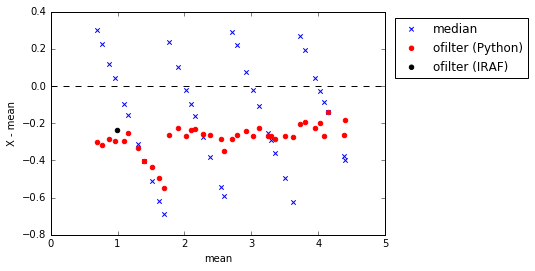

In [9]:
plt.scatter(sky_mean, sky_med - sky_mean, color='b', marker='x', label='median')
plt.scatter(sky_mean, sky_ofil - sky_mean, color='r', marker='o', label='ofilter (Python)')
plt.scatter([0.9868], [0.7501699 - 0.9868], color='k', marker='o', label='ofilter (IRAF)')
plt.xlabel('mean')
plt.ylabel('X - mean')
plt.axhline(0, color='k', linestyle='--')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', scatterpoints=1)

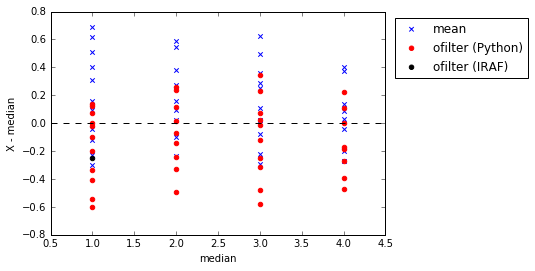

In [10]:
plt.scatter(sky_med, sky_mean - sky_med, color='b', marker='x', label='mean')
plt.scatter(sky_med, sky_ofil - sky_med, color='r', marker='o', label='ofilter (Python)')
plt.scatter([1], [0.7501699 - 1], color='k', marker='o', label='ofilter (IRAF)')
plt.xlabel('median')
plt.ylabel('X - median')
plt.axhline(0, color='k', linestyle='--')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', scatterpoints=1)

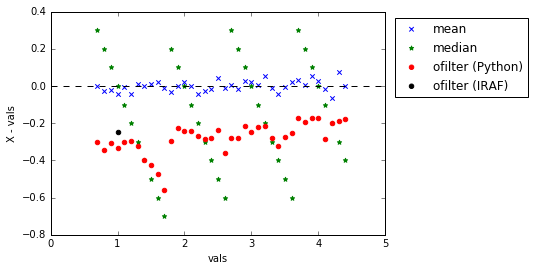

In [11]:
plt.scatter(sky_vals, sky_mean - sky_vals, color='b', marker='x', label='mean')
plt.scatter(sky_vals, sky_med - sky_vals, color='g', marker='*', label='median')
plt.scatter(sky_vals, sky_ofil - sky_vals, color='r', marker='o', label='ofilter (Python)')
plt.scatter([1], [0.7501699 - 1], color='k', marker='o', label='ofilter (IRAF)')
plt.xlabel('vals')
plt.ylabel('X - vals')
plt.axhline(0, color='k', linestyle='--')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', scatterpoints=1)

### Try with Other Skewed Distribution

In [12]:
from scipy.stats import gumbel_r

# Populate desired background values
vals = np.arange(0.1, 4.6, 0.1)

# Initialize arrays to store results
sky_vals = []
sky_ofil = []
sky_med = []
sky_mean = []

# Generate results
for i, val in enumerate(vals):
    np.random.seed(i)  # Does this control Scipy?
    data = gumbel_r.rvs(loc=val, size=(50, 50))
    
    try:
        msky = ofiltsky.fitsky_ofilter(data, sigclip_sigma=None)[0]
    except ValueError as e:
        print('i={0}, val={1:.1f}, errmsg={2}'.format(i, val, str(e)))
        continue
        
    sky_vals.append(val)
    sky_ofil.append(msky)
    sky_med.append(np.median(data))
    sky_mean.append(data.mean())
    
# Convert result to Numpy arrays
sky_vals = np.asarray(sky_vals)
sky_ofil = np.asarray(sky_ofil)
sky_med = np.asarray(sky_med)
sky_mean = np.asarray(sky_mean)
    
print()
print('Number of data points for plotting:', sky_ofil.size)


Number of data points for plotting: 45


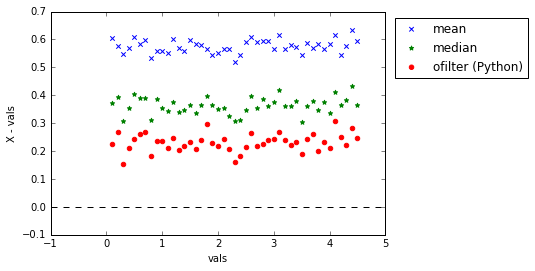

In [13]:
plt.scatter(sky_vals, sky_mean - sky_vals, color='b', marker='x', label='mean')
plt.scatter(sky_vals, sky_med - sky_vals, color='g', marker='*', label='median')
plt.scatter(sky_vals, sky_ofil - sky_vals, color='r', marker='o', label='ofilter (Python)')
plt.xlabel('vals')
plt.ylabel('X - vals')
plt.axhline(0, color='k', linestyle='--')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', scatterpoints=1)

Display histogram of the data from the last iteration above:

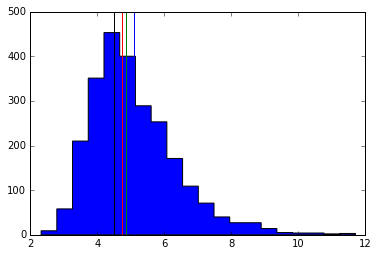

In [14]:
h = plt.hist(data.flatten(), bins=20, histtype='stepfilled')
plt.axvline(msky, color='r')
plt.axvline(np.median(data), color='g')
plt.axvline(data.mean(), color='b')
plt.axvline(val, color='k')